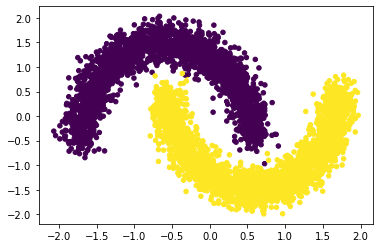

In [290]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=5000, noise=0.1, random_state=42)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)

Let's use a two layer MLP to do the classfication

normal case

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [3000, 1000])
test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
architecture = OrderedDict([
    ('fc1', nn.Linear(2, 16)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(16, 2))])
model = nn.Sequential(architecture)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
# FULL BATCH TRAINING
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [298]:
gradients = {
    'fc1.weight': [],
    'fc1.bias': [],
    'fc2.weight': [],
    'fc2.bias': []}

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'test_loss': [],
    'test_acc': []
}
for epoch in range(100):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        history['train_loss'].append(loss.item())
        history['train_acc'].append(torch.mean((output.argmax(1) == target).float()).item())
        for name, param in model.named_parameters():
            if name in gradients.keys():
                gradients[name].append(param.grad.clone().numpy())
        optimizer.step()
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)
            history['val_loss'].append(loss.item())
            history['val_acc'].append(torch.mean((output.argmax(1) == target).float()).item())
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            history['test_loss'].append(loss.item())
            history['test_acc'].append(torch.mean((output.argmax(1) == target).float()).item())

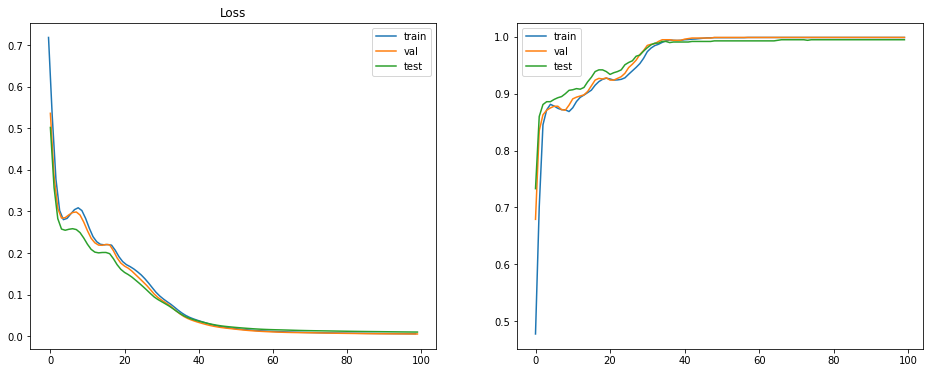

In [300]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
import numpy as np
axs[0].plot(np.arange(0, 100)-0.5, history['train_loss'], label='train')
axs[0].plot(history['val_loss'], label='val')
axs[0].plot(history['test_loss'], label='test')
axs[0].legend()
axs[0].set_title('Loss')
axs[1].plot(history['train_acc'], label='train')
axs[1].plot(history['val_acc'], label='val')
axs[1].plot(history['test_acc'], label='test')
axs[1].legend()


Gradient of each layer

vector like

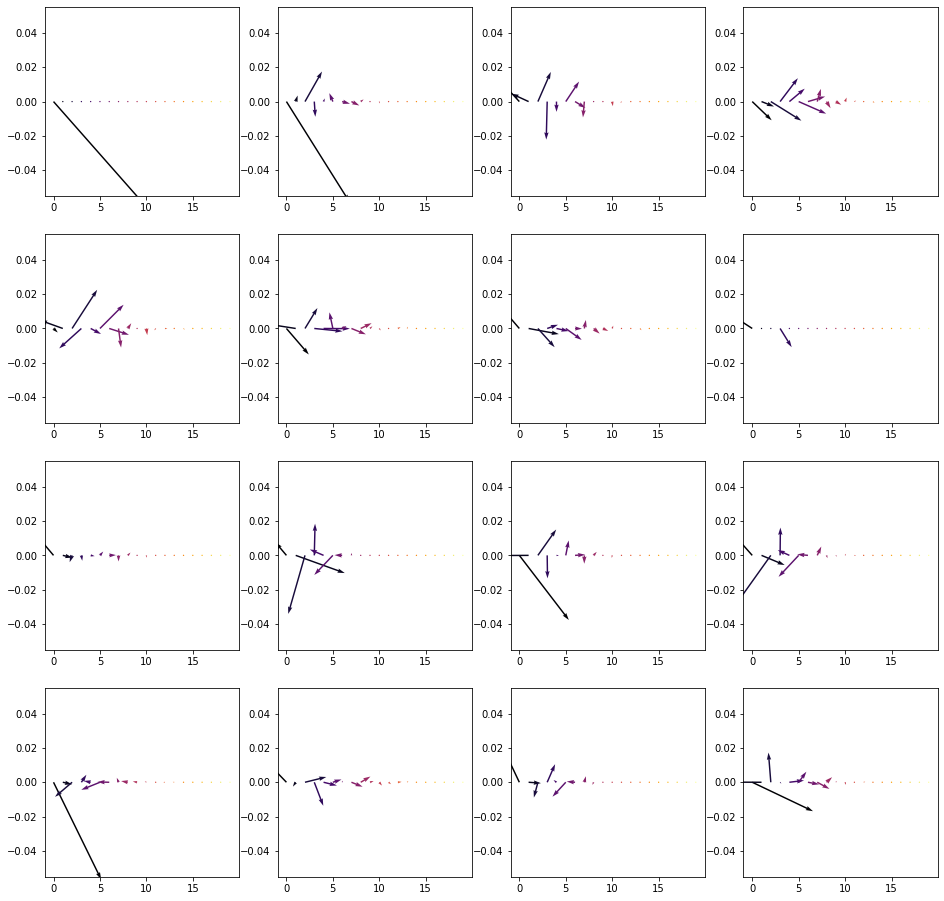

In [331]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    gradient = np.array(gradients['fc1.weight'])[::5][:, i, :]
    origin_points = np.zeros_like(gradient)
    origin_points[:, 0] = np.arange(0, len(gradient))
    ax.quiver(origin_points[:, 0], origin_points[:, 1], gradient[:, 0], gradient[:, 1],
        np.arange(len(gradient)), 
        cmap='inferno')    



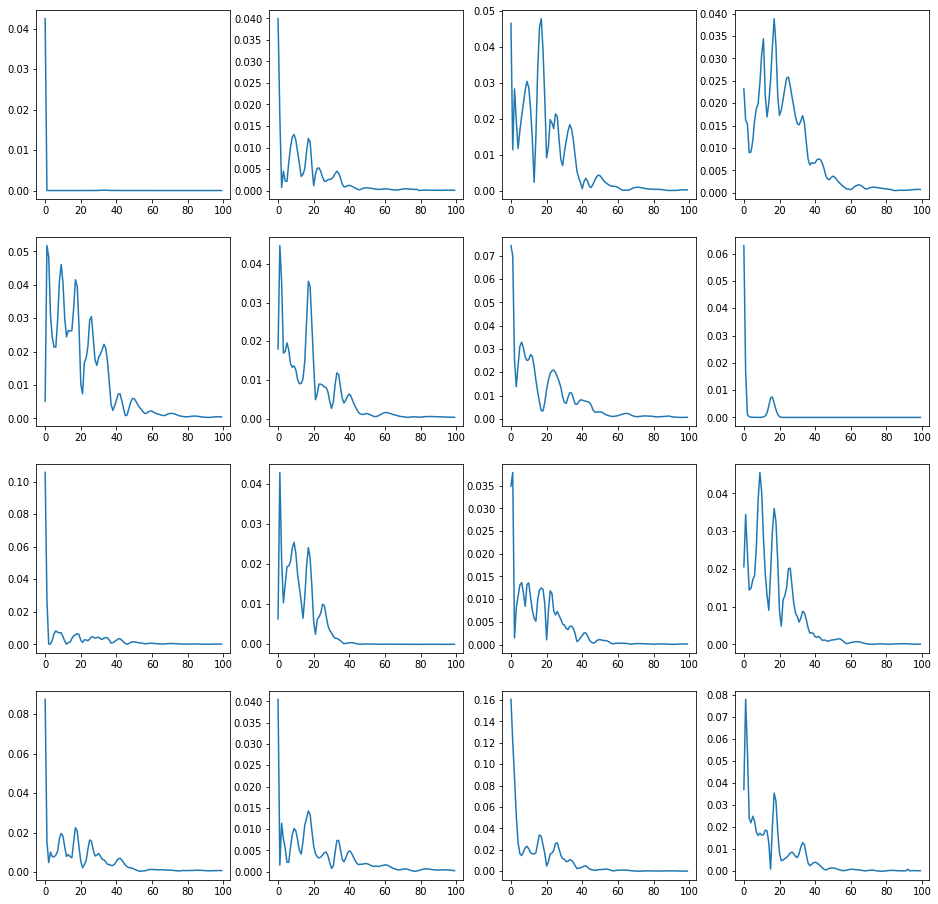

In [332]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    gradient = np.array(gradients['fc1.weight'])[:, i, :]
    norm = np.linalg.norm(gradient, axis=1)
    ax.plot(norm)  


what if there is label corruption

In [333]:
from Noise import MyDataSetNoisyWrapper
uniform_noisy_dataset = MyDataSetNoisyWrapper(train_dataset, 
    corruption_prob=0.5, num_classes=10, noise_type='uniform')
